<a href="https://colab.research.google.com/github/wellia/Machine_Learning/blob/main/Clustering_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# do this to install pyclustering
!pip install pyclustering

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(1)

In [ ]:
# load dataset into Pandas DataFrame
url = "clustering.csv"
df = pd.read_csv(url)

features = ['height', 'length', 'width', 'std', 'min', 'max', 'kurtosis']
# Separating out the features
X = df.loc[:, features].values
# Separating out the target, y_true will be used as ground base 
y_true = df.loc[:,['Class']].values
#print(set(y_true.flatten())) # uncomment to find out the classes - unique values of y_true are 0, 1, and 2
# Standardizing the features
x_true = StandardScaler().fit_transform(X)


## Part 1: Clustering

Read the file and separate the class and feature matrix.

2. Determine the number of clusters from the dataset. Is this same as the actual number of classes in the dataset?

Explaination: From the graph we can see the sum of squared distances drops significantly until point 3 then it flattens. the elbow forms at k = 3. Therefore the optimal number of clusters is 3. It is the same as the actual number of classes in the dataset

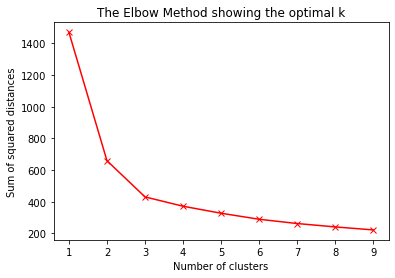

In [ ]:
# finding number of clusters

def draw_elbow (x):
    totSqrdDist=[]
    kRange=range(1, 10)
    for k in kRange:
        kmns=KMeans(n_clusters=k).fit(x)
        totSqrdDist.append(kmns.inertia_)
    plt.plot(kRange,totSqrdDist,'-xr')
    plt.ylabel('Sum of squared distances')
    plt.xlabel('Number of clusters')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
draw_elbow(x_true)

Answer: The purity score using three clusters is 91.9%.


3. Perform K-Means clustering on the complete dataset and report purity score. 

In [ ]:
# declare purity score function
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred) #confusion matrix
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) #return purity

# reference: https://stackoverflow.com/questions/34047540/python-clustering-purity-metric/51672699#51672699

In [ ]:
# perform K-Means clustering with number of cluster input as in task 2 

# define kMeans functions
def calculate_kmeans(num_clusters, data):
    np.random.seed(1)
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    y_pred = kmeans.fit_predict(data)
    return y_pred

# perform K-means 
y_pred = calculate_kmeans(3, x_true)
ps = purity_score(y_true, y_pred)
print('Purity score:', round(ps*100, 2))

Purity score: 91.9


4. Compare the purity score of k-means clustering for different distance metrics.

Explanation: Purity score for  Manhattan  :  89%, Purity score for  Euclidean  :  92%, 
Purity score for  Chebyshev  :  89%, Purity score for  Minkowski  :  91%

Select the best distance metric and explain why this distance metric is best for the given dataset.

In [ ]:
from pyclustering.cluster.kmeans import kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.encoder import cluster_encoder, type_encoding
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.kmeans import kmeans as pKmeans

metric_names = ['Manhattan','Euclidean','Chebyshev','Minkowski']
metric_list = []
metric_list.append(distance_metric(type_metric.MANHATTAN))
metric_list.append(distance_metric(type_metric.EUCLIDEAN))
metric_list.append(distance_metric(type_metric.CHEBYSHEV))
metric_list.append(distance_metric(type_metric.MINKOWSKI, degree=4))

# find initial clusters
kmin, kmax = 1, 10
elbow_instance = elbow(x_true, kmin, kmax)
elbow_instance.process()
num_of_clusters = elbow_instance.get_amount()   # amount of clusters
# perform cluster analysis using K-Means algorithm
initial_centers = kmeans_plusplus_initializer(x_true, num_of_clusters).initialize()
    
for i, dist_metric in enumerate(metric_list):
    
    # process kmeans to get clusters
    kmeans_instance = pKmeans(x_true, initial_centers, metric=dist_metric)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    # labelling
    type_repr = kmeans_instance.get_cluster_encoding()
    encoder = cluster_encoder(type_repr, clusters, x_true)
    encoder.set_encoding(type_encoding.CLUSTER_INDEX_LABELING)
    y_pred = encoder.get_clusters()

    # check purity
    purity = purity_score(y_true, y_pred)
    print('Purity score for ', metric_names[i], ' : ', round(purity*100,2), '%') 
    

Purity score for  Manhattan  :  88.57 %
Purity score for  Euclidean  :  91.9 %
Purity score for  Chebyshev  :  89.52 %
Purity score for  Minkowski  :  90.95 %


Explanation: The best distance metric is Euclidean because k-means itself minimises the sum of squares, which is the very definition of the Euclidean distance

Answer: The recommended feature set for both Anova and chi-squared is ['height', 'length', 'min'],
because for this dataset with selected features, ANOVA and chi-squared return the same purity score 0.85.

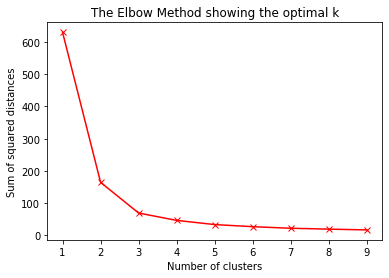

Purity score of kmeans with feature selection using Anova is  84.76 %
Original number of features: 7
Reduced number of features: 3
New features: ['height', 'length', 'min']


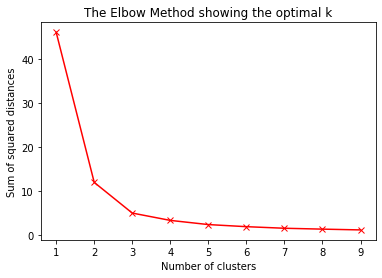

Purity score of kmeans with feature selection using Chi-squared is  84.76 %
Reduced number of features: 3
New features: ['height', 'length', 'min']


In [ ]:
# Feature Selection with Univariate Statistical Tests
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def get_new_features(kbest):
    new_features = []
    new_features_bools = kbest.get_support()

    for bool, feature in zip(new_features_bools, features):
        if bool:
            new_features.append(feature)
            
    return new_features
        
num_features = 3 #requirement

# Anova
kbest = SelectKBest(f_classif, k=num_features)
x_anova = kbest.fit_transform(x_true, y_true.ravel())
draw_elbow(x_anova) # using selected features, get the optimal number of clusters
num_of_clusters = 3 # at plot, elbow form at 3
y_pred = calculate_kmeans(num_of_clusters, x_anova)
ps = purity_score(y_true, y_pred)
print('Purity score of kmeans with feature selection using Anova is ', round(ps*100,2), '%')
print('Original number of features:', x_true.shape[1])
print('Reduced number of features:', x_anova.shape[1])

new_features = get_new_features(kbest)
print('New features:', new_features)
        
# Chi-squared
normed_x = MinMaxScaler().fit_transform(x_true) #scale it, so there is no negative values
kbest = SelectKBest(chi2, k=num_features)
x_chi = kbest.fit_transform(normed_x, y_true)
draw_elbow(x_chi) # using selected features, get the optimal number of clusters
num_of_clusters = 3 # at plot, elbow form at 3
y_pred = calculate_kmeans(3, x_chi)
ps = purity_score(y_true, y_pred)
print('Purity score of kmeans with feature selection using Chi-squared is ', round(ps*100,2), '%')
print('Reduced number of features:', x_chi.shape[1])

new_features = get_new_features(kbest)
print('New features:', new_features)

5. Use selection criteria (ANOVA, Chi-squared) to select best three features and use them for K-Means clustering. Recommend feature sets based on the purity score

# Part-2 (Dimensionality Reduction using PCA/SVD)

1. For the dataset (clustering.csv), perform PCA.
    - plot the captured variance with respect to increasing latent dimensionality.
  
  What is the minimum dimension that captures:
    - at least 89% variance? Answer: *3 dimensions (without roundup)*
    - at least 99% variance? Answer: *4 dimensions (without roundup)*

Cumulative captured variances:  [0.71874303 0.88982486 0.9866825  0.99644885 0.99912222 0.99988394
 1.        ]


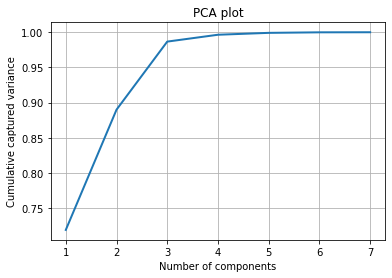

In [ ]:
pca = PCA(n_components=7)
pca_data = pca.fit_transform(x_true)
percentage_var_explained = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
print('Cumulative captured variances: ', cum_var_explained)

# plot the PCA 
plt.figure(1, figsize=(6,4))
plt.clf()
x = range(1, 8)
plt.plot(x, cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.title('PCA plot')
plt.xlabel('Number of components')
plt.ylabel('Cumulative captured variance')
plt.show()


2. Determine the purity of clusters formed by the number of principal components which captured 89% and 99% variances respectively. Plot a line graph of the purity scores against the captured variances. Discuss your findings. __(7 marks)__

The line graph shows that the purity score of 69% captured variances (0.86) is lower significantly from the purity score of 74% captured variances (0.92). The score stays at 0.92 for captured variances 79% to 94% , but drops slightly for 99% captured variances to 0.919. The cause of the drop, at 99% captured variances, PCA now uses 4 dimensions, the fourth principle component could contain redundant features or having noise, making the clustering result less accurate.

Explaination: With at least 89% variances, the purity score is 0.92 (0.9238) whereas with at least 99% variances, the purity score is 0.919. 

In [ ]:
# capture 89% variance
np.random.seed(1)
pca89 = PCA(0.89)
x_pca89 = pca89.fit_transform(x_true)
#draw_elbow(x_pca89)  # comment-out this line for better display in result block
n_clusters = 3        # from the elbow, the optimal number of cluster is 3
y_pred89 = calculate_kmeans(n_clusters, x_pca89)
ps89 = purity_score(y_true, y_pred89)

# capture 99% variance
np.random.seed(1)
pca99 = PCA(0.99)
x_pca99 = pca99.fit_transform(x_true)
#draw_elbow(x_pca99)  # comment-out this line for better display in result block
n_clusters = 3        # from the elbow, the optimal number of cluster is 3
y_pred99 = calculate_kmeans(n_clusters, x_pca99)
ps99 = purity_score(y_true, y_pred99)

# print results

# print result from 89%
print('\npurity score for 89% is ', ps89)
print('number of features for 89%:', x_pca89.shape[1])

df_pca = pd.DataFrame(pca89.components_,columns=features,index = ['PC-1','PC-2','PC-3'])
print('\nPCA components correlations in the original data features\n')
print(df_pca)

# print result from 99%
print('\npurity score for 99% is ', ps99)
print('number of features for 99%:', x_pca99.shape[1])

df_pca = pd.DataFrame(pca99.components_,columns=features,index = ['PC-1','PC-2','PC-3','PC-4'])
print('\nPCA components correlations in the original data features\n')
print(df_pca)



purity score for 89% is  0.9238095238095239
number of features for 89%: 3

PCA components correlations in the original data features

        height    length     width       std       min       max  kurtosis
PC-1  0.444474  0.441571  0.277017  0.423563  0.432819 -0.118692  0.387161
PC-2 -0.026564 -0.084003  0.529151 -0.205975  0.116690 -0.716882 -0.377193
PC-3  0.025871 -0.059839  0.629692 -0.211880  0.216483  0.679506 -0.213897

purity score for 99% is  0.919047619047619
number of features for 99%: 4

PCA components correlations in the original data features

        height    length     width       std       min       max  kurtosis
PC-1  0.444474  0.441571  0.277017  0.423563  0.432819 -0.118692  0.387161
PC-2 -0.026564 -0.084003  0.529151 -0.205975  0.116690 -0.716882 -0.377193
PC-3  0.025871 -0.059839  0.629692 -0.211880  0.216483  0.679506 -0.213897
PC-4  0.193640  0.295457 -0.332816  0.263407  0.199630  0.092465 -0.804150


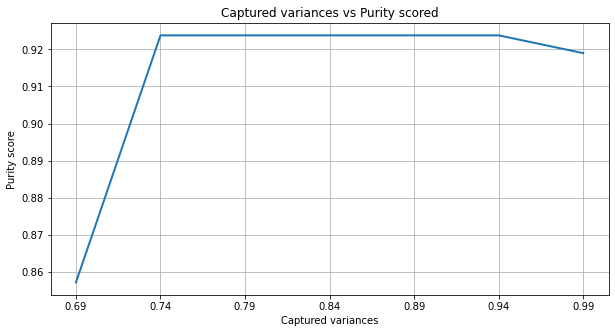

((0.69, 0.8571), (0.74, 0.9238), (0.79, 0.9238), (0.84, 0.9238), (0.89, 0.9238), (0.94, 0.9238), (0.99, 0.919))


In [ ]:
# plot a line chart number of captured variance
variances = []
y_purities = []
n_clusters = 3 # as calculated previously
for x in (0.69, 0.74, 0.79, 0.84, 0.89, 0.94, 0.99):
    x_pca = PCA(x).fit_transform(x_true)
    y_pred = calculate_kmeans(n_clusters, x_pca) 
    ps = purity_score(y_true, y_pred)
    variances.append(x)
    y_purities.append(round(ps,4))

plt.figure(figsize=(10,5))
plt.plot(variances, y_purities, linewidth=2)
plt.grid()
plt.xticks(variances)
plt.title('Captured variances vs Purity scored')
plt.xlabel('Captured variances')
plt.ylabel('Purity score')
plt.show()

result = zip(variances, y_purities)
print(tuple(result))

3. Let's assume you have two datasets one is linear and another is curved structural data. Check whether we can apply PCA on these datasets. 

Explaination: We definitely can apply PCA on linear data because PCA performs a linear rotation. For curved structural data, we still can apply PCA but the result will be meaningless. However, we can apply Kernel PCA, which is the extension of PCA. Using the kernel trick, the data is temporarily projected to a higher-dimensional space then compress datasets consisting of nonlinear features onto a lower-dimensional space where the classes became linearly separable

References: 
https://medium.com/@ODSC/implementing-a-kernel-principal-component-analysis-in-python-495f04a7f85f

https://en.wikipedia.org/wiki/Kernel_principal_component_analysis#:~:text=In%20the%20field%20of%20multivariate,a%20reproducing%20kernel%20Hilbert%20space.
